<a href="https://colab.research.google.com/github/nneguss1/DATA-690-WANG/blob/master/Assignment_09/Data690_Assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vulernablity of National Harbor, MD for Sea level rise**

# INTRODUCTION

Flood risk modeling and risk assessments in areas that are highly exposed to sea-level rise and flooding has not been
extensively studied. Additionally, holistic coastal flood risk assessments and sea level rise at local scale still needs to be further researched. The main objective of this study is to assess flood risk due to sea-level rise and assess the associated increased cost in current property values based on the area of the property as well as its respective lot in the National Harbor area.As previously stated, this study is distinct from previous studies as it provides policy implications for urban planners and policy makers at local level governments.

# APPROACH

This study utilized datasets that contain detailed information on property land values and tax assessments, insurance payouts, flood elevation and flood depth for the area of interest. 
A combination of gis processing and data grouping was used to generate the data. The following steps were followed to compile the data into an analysis dataframe.

*   Generate a fishnet grid to cover the study area.
*   Intersect the Property Flattened data with the fishnet grid to transfer the area information into individual squares within the fishnet. Since the Property Flattened data contains both the assessed value and the plot size, the cost will have to be weighted using an area weighting method taking the total area of the plot from the dataset and computing how much of the fraction of the area is within the fishnet grid.
*   Assign elevation for each area in the fishnet grid from the DEM using the zonal statistics function in the GIS. This will assign average elevation for the individual areas in the grid.
*   Assign the base flood information obtained from the BFE data into the grids and compute the flooding depth as the difference between the ground elevation and the base flood elevation. Depth values that are computed negative will mean that the ground elevation is higher than the flood elevation and therefore above flooding.
*  For every fishnet area with a positive flooding depth compute the damage cost using the cost of flooding model developed by FEMA. The maximum the cost will go for each area will be limited to the initial cost generated from the Property Flattened dataset since it should not cost more than what the property is assessed.

# Results and Discussion

In [1]:
# Start with installing the necessary libraries and importing them into the notebook. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install geopandas
%pip install libpysal
%pip install mapclassify

     |████████████████████████████████| 972kB 5.2MB/s 
     |████████████████████████████████| 14.8MB 252kB/s 
     |████████████████████████████████| 6.5MB 9.5MB/s 
     |████████████████████████████████| 2.4MB 5.1MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379082 sha256=e8d49e8178a84930778717f4a44be781c78f25d11b21c6df59d2705a45b6b29b
  Stored in directory: /root/.cache/pip/wheels/68/44/db/3d7a8b7d9ae5dba0cfcfb37f14e2a6e6f26b03557bdf1cf06d
Successfully built libpysal


In [6]:
#from google.colab import drive
filepath = '/content/drive/MyDrive/Data601/Final_DF_combined.shp'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

The shapefile in the google drive folder is a compilation of the fishnet grid with the intersection of the property information and the DEM elevation grid. It also has information for the flood elevation for the grid and also the flood elevation for assumed sea-level rise value (assuming 1 foot increas in flood elevation).

In [7]:
newDF = gpd.read_file(filepath)
newDF.sample(5)

,FID_Fishne,Id,LAND_AREA1,MAIL_ZIP5,SHAPE_AREA,ELE_Y_N,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,geometry
127749,132587,8014,192970.8,20737,9687.480623,Y,9.0,10.0,111833,132587,1444,5776.0,9,12,10.462604,"POLYGON ((-8568502.323 4679812.153, -8568532.3..."
15010,15523,9688,12978.0,20744,548.450355,Y,9.0,10.0,306233,15523,75,300.0,182,184,183.000000,"POLYGON ((-8570902.323 4680022.153, -8570910.5..."
963,1159,871,994910.4,20737,1015.127359,Y,9.0,10.0,556533,1159,160,640.0,5,8,7.237500,"POLYGON ((-8570919.823 4678672.153, -8570932.3..."
2239,2479,1824,4340754.0,20242,9687.480623,Y,9.0,10.0,4129667,2479,1444,5776.0,8,25,15.252078,"POLYGON ((-8572612.323 4678912.153, -8572642.3..."
26789,27588,16189,26470.0,20744,1906.906678,Y,9.0,10.0,237567,27588,304,1216.0,203,206,205.236842,"POLYGON ((-8569792.323 4680832.004, -8569820.8..."


The assessed cost for the plot was obtained from the Property Flattened shapefile and had to be assigned to each grid using the area weighting method. In addition the flood depth was computed as the difference between the water surface elevation and the land elevation. Areas with negative vlaue are considered to be above the water elevation and therefore will not be impacted with the flooding. 

In [8]:
newDF['area_cost'] = (newDF['SHAPE_AREA']/newDF['LAND_AREA1'])*newDF['CURR_ASSES']
newDF['BaseFLD'] = newDF['EX_FLD_ELV']-newDF['MEAN']
newDF.loc[newDF['BaseFLD'] < 0,'BaseFLD'] = 0
newDF['SeaLevel_1'] = newDF['SEA_LEVEL']-newDF['MEAN']
newDF.loc[newDF['SeaLevel_1'] < 0,'SeaLevel_1'] = 0
newDF['SeaLevel_2'] = newDF['SEA_LEVEL']-newDF['MEAN']+1
newDF.loc[newDF['SeaLevel_2'] < 0,'SeaLevel_2'] = 0
newDF['SeaLevel_3'] = newDF['SEA_LEVEL']-newDF['MEAN']+2
newDF.loc[newDF['SeaLevel_3'] < 0,'SeaLevel_3'] = 0
newDF.sample(10)

,FID_Fishne,Id,LAND_AREA1,MAIL_ZIP5,SHAPE_AREA,ELE_Y_N,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,geometry,area_cost,BaseFLD,SeaLevel_1,SeaLevel_2,SeaLevel_3
133260,148252,68097,3629.0,20745,248.832967,Y,10.0,11.0,683333,148252,40,160.0,168,168,168.000000,"POLYGON ((-8572487.530 4690034.995, -8572490.5...",46854.719663,0.000000,0.000000,0.000000,0.000000
15601,16129,10056,14853960.0,20405,9687.480626,Y,9.0,10.0,26029033,16129,1444,5776.0,73,117,97.135734,"POLYGON ((-8575042.323 4680082.153, -8575072.3...",16975.658538,0.000000,0.000000,0.000000,0.000000
40232,41398,23565,31276.0,20744,2893.703835,Y,9.0,10.0,553267,41398,454,1816.0,33,41,38.262115,"POLYGON ((-8574592.323 4681852.153, -8574604.5...",51189.117530,0.000000,0.000000,0.000000,0.000000
40609,41783,23748,84488.0,20871,6943.245668,Y,9.0,10.0,19467,41783,1058,4232.0,111,129,119.629490,"POLYGON ((-8569042.323 4681852.153, -8569072.3...",1599.803089,0.000000,0.000000,0.000000,0.000000
85662,88203,51522,10010.0,20744,5436.480865,Y,10.0,11.0,308000,88203,842,3368.0,74,79,76.127078,"POLYGON ((-8572678.278 4686265.222, -8572684.4...",167276.334293,0.000000,0.000000,0.000000,0.000000
86687,89305,52285,4191343.2,20737,9621.011872,Y,10.0,11.0,4749600,89305,1470,5880.0,7,10,8.197959,"POLYGON ((-8571802.323 4686382.153, -8571826.3...",10902.461527,1.802041,2.802041,3.802041,4.802041
13012,13493,8513,540144.0,20737,9687.480626,Y,9.0,10.0,53900,13493,1444,5776.0,10,12,11.294321,"POLYGON ((-8568382.323 4679872.153, -8568412.3...",966.696299,0.000000,0.000000,0.000000,0.705679
30333,31237,18118,14853960.0,20405,9687.480626,Y,9.0,10.0,26029033,31237,1482,5928.0,77,102,91.819838,"POLYGON ((-8574382.323 4681072.153, -8574412.3...",16975.658538,0.000000,0.000000,0.000000,0.000000
5962,6333,4581,18179.0,20744,6575.741282,Y,9.0,10.0,250167,6333,1015,4060.0,163,172,167.698522,"POLYGON ((-8569772.438 4679364.968, -8569787.3...",90490.866889,0.000000,0.000000,0.000000,0.000000
12343,12814,8149,36523.0,22101,594.420994,Y,9.0,10.0,23700,12814,96,384.0,149,167,158.802083,"POLYGON ((-8571832.323 4679854.703, -8571832.3...",385.723450,0.000000,0.000000,0.000000,0.000000


In [ ]:
newDF['BaseFLD']

0         6.592105
1         5.865014
2         5.492347
3         6.600000
4         6.917051
            ...   
134035    0.000000
134036    0.000000
134037    0.000000
134038    0.000000
134039    0.000000
Name: BaseFLD, Length: 134040, dtype: float64

In [9]:
import numpy as np

In [10]:
#replaces the infinity to non-infitnity
newDF['area_cost'].replace([np.inf, -np.inf], np.nan, inplace=True)
newDF['BaseFLD'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
#gets a sum of the number of rows in that column that have a null value
newDF['BaseFLD'].isnull().sum()

0

In [12]:
#gets a sum of the number of rows in that column that have a null value
newDF['area_cost'].isnull().sum()

605

In [13]:
#Take rows where not na and re-assign the variable to the "Area_Cost" column
newDF = newDF[newDF['area_cost'].notna()]

In [14]:
#gets a sum of the number of rows in the "Area Cost" column that have a null value
newDF['area_cost'].isnull().sum()

0

The cost of flood damage was computed using a logathermic relationship obtained from FEMA. The formula relates flooding depth with cost of damage per square foot. From our dataframe, the Flood Depth column and the Area column were used to solve for the cost of flooding damage for the grid. These cost is further compared with the assessed cost for the grid and the lower of the two values was saved as the cost of flooding. This will check so that the maximum cost for the area will be what the area is assessed for. 

In [30]:
newDF['BaseCost']= (9.6073*(np.log(newDF['BaseFLD']))+27.339)*newDF['SHAPE_AREA']
newDF.loc[newDF.area_cost<newDF.BaseCost, 'BaseCost']=newDF.area_cost
newDF['SeaCOST_1']= (9.6073*(np.log(newDF['SeaLevel_1']))+27.339)*newDF['SHAPE_AREA']
newDF.loc[newDF.area_cost<newDF.SeaCOST_1, 'SeaCOST_1']=newDF.area_cost
newDF['SeaCOST_2']= (9.6073*(np.log(newDF['SeaLevel_2']))+27.339)*newDF['SHAPE_AREA']
newDF.loc[newDF.area_cost<newDF.SeaCOST_2, 'SeaCOST_2']=newDF.area_cost
newDF['SeaCOST_3']= (9.6073*(np.log(newDF['SeaLevel_3']))+27.339)*newDF['SHAPE_AREA']
newDF.loc[newDF.area_cost<newDF.SeaCOST_3, 'SeaCOST_3']=newDF.area_cost
newDF.head(20)


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,FID_Fishne,Id,LAND_AREA1,MAIL_ZIP5,SHAPE_AREA,ELE_Y_N,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,geometry,area_cost,BaseFLD,SeaLevel_1,SeaLevel_2,SeaLevel_3,BaseCost,SeaCOST_1,SeaCOST_2,SeaCOST_3
0,3,3,994910.4,20737,1504.894799,Y,9.0,10.0,556533,3,228,912.0,-1,4,2.407895,"POLYGON ((-8570512.323 4678212.008, -8570524.2...",841.808084,6.592105,7.592105,8.592105,9.592105,841.808084,841.808084,841.808084,841.808084
1,4,4,994910.4,20737,4690.365316,Y,9.0,10.0,556533,4,726,2904.0,1,4,3.134986,"POLYGON ((-8570482.323 4678203.273, -8570483.9...",2623.696647,5.865014,6.865014,7.865014,8.865014,2623.696647,2623.696647,2623.696647,2623.696647
2,5,5,994910.4,20737,5167.544467,Y,9.0,10.0,556533,5,784,3136.0,-1,5,3.507653,"POLYGON ((-8570452.323 4678212.579, -8570454.2...",2890.621130,5.492347,6.492347,7.492347,8.492347,2890.621130,2890.621130,2890.621130,2890.621130
3,7,6,994910.4,20737,1608.605354,Y,9.0,10.0,556533,7,255,1020.0,-1,5,2.400000,"POLYGON ((-8570422.323 4678222.108, -8570423.3...",899.821696,6.600000,7.600000,8.600000,9.600000,899.821696,899.821696,899.821696,899.821696
4,16,11,994910.4,20737,1448.211549,Y,9.0,10.0,556533,16,217,868.0,-1,4,2.082949,"POLYGON ((-8570542.323 4678232.984, -8570543.3...",810.100606,6.917051,7.917051,8.917051,9.917051,810.100606,810.100606,810.100606,810.100606
5,17,12,994910.4,20737,9206.029829,Y,9.0,10.0,556533,17,1373,5492.0,-1,4,2.772032,"POLYGON ((-8570512.323 4678222.153, -8570533.8...",5149.669155,6.227968,7.227968,8.227968,9.227968,5149.669155,5149.669155,5149.669155,5149.669155
6,18,13,994910.4,20737,9687.480625,Y,9.0,10.0,556533,18,1482,5928.0,2,4,2.912281,"POLYGON ((-8570482.323 4678222.153, -8570512.3...",5418.983111,6.087719,7.087719,8.087719,9.087719,5418.983111,5418.983111,5418.983111,5418.983111
7,19,14,994910.4,20737,9687.480626,Y,9.0,10.0,556533,19,1444,5776.0,2,5,3.034626,"POLYGON ((-8570452.323 4678222.153, -8570482.3...",5418.983112,5.965374,6.965374,7.965374,8.965374,5418.983112,5418.983112,5418.983112,5418.983112
8,20,15,994910.4,20737,9687.480625,Y,9.0,10.0,556533,20,1482,5928.0,-1,5,3.786100,"POLYGON ((-8570422.323 4678222.153, -8570452.3...",5418.983111,5.213900,6.213900,7.213900,8.213900,5418.983111,5418.983111,5418.983111,5418.983111
9,21,16,994910.4,20737,5681.341139,Y,9.0,10.0,556533,21,849,3396.0,-1,5,3.007067,"POLYGON ((-8570392.323 4678244.162, -8570393.6...",3178.028723,5.992933,6.992933,7.992933,8.992933,3178.028723,3178.028723,3178.028723,3178.028723


In [16]:
##The size of the dataframe
len(newDF)
  

133435

In [31]:
newDF.describe()

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,FID_Fishne,Id,LAND_AREA1,SHAPE_AREA,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,area_cost,BaseFLD,SeaLevel_1,SeaLevel_2,SeaLevel_3,BaseCost,SeaCOST_1,SeaCOST_2,SeaCOST_3
count,133435.000000,133435.000000,1.334350e+05,133435.000000,133435.000000,133435.000000,1.334350e+05,133435.000000,133435.000000,133435.00000,133435.000000,133435.000000,133435.000000,1.334350e+05,133435.000000,133435.000000,133435.000000,133435.000000,1.334350e+05,1.334350e+05,1.334350e+05,1.334350e+05
mean,69482.013917,38185.441106,7.912302e+05,4724.547161,9.577847,10.577847,4.579634e+06,69482.013917,715.596665,2862.38666,93.662645,100.435793,97.140964,4.812134e+05,0.353987,0.408309,0.466038,0.527355,-inf,-inf,-inf,-inf
std,40886.385792,21788.997020,2.549536e+06,3645.213045,0.493905,0.493905,4.616195e+07,40886.385792,553.795868,2215.18347,62.474054,63.014109,62.738361,3.962009e+07,1.713597,1.912265,2.116618,2.326368,NaN,NaN,NaN,NaN
min,3.000000,3.000000,1.000000e+00,0.024166,9.000000,10.000000,0.000000e+00,3.000000,1.000000,4.00000,-13.000000,-1.000000,-1.446298,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf
25%,34410.500000,19270.000000,1.295300e+04,1152.443865,9.000000,10.000000,2.396330e+05,34410.500000,173.000000,692.00000,41.000000,46.000000,43.940548,3.233707e+03,0.000000,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf
50%,68952.000000,37265.000000,2.242600e+04,4116.388371,10.000000,11.000000,3.223000e+05,68952.000000,622.000000,2488.00000,80.000000,87.000000,83.297945,1.697566e+04,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,103490.500000,57981.500000,1.672704e+05,8923.324781,10.000000,11.000000,4.796670e+05,103490.500000,1351.000000,5404.00000,147.000000,153.000000,150.122346,7.309279e+04,0.000000,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf
max,304653.000000,77207.000000,1.485396e+07,9687.480626,10.000000,11.000000,8.253880e+08,304653.000000,1521.000000,6084.00000,284.000000,289.000000,286.688172,6.885803e+09,11.446298,12.446298,13.446298,14.446298,4.606861e+05,4.709576e+05,4.802007e+05,4.886026e+05


In [32]:
newDF['BaseCost'].sum()

newDF['BaseCost'].replace([np.inf, -np.inf], np.nan, inplace=True)

newDF['SeaCOST_1'].replace([np.inf, -np.inf], np.nan, inplace=True)
newDF['SeaCOST_2'].replace([np.inf, -np.inf], np.nan, inplace=True)
newDF['SeaCOST_3'].replace([np.inf, -np.inf], np.nan, inplace=True)
newDF.head()

,FID_Fishne,Id,LAND_AREA1,MAIL_ZIP5,SHAPE_AREA,ELE_Y_N,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,geometry,area_cost,BaseFLD,SeaLevel_1,SeaLevel_2,SeaLevel_3,BaseCost,SeaCOST_1,SeaCOST_2,SeaCOST_3
0,3,3,994910.4,20737,1504.894799,Y,9.0,10.0,556533,3,228,912.0,-1,4,2.407895,"POLYGON ((-8570512.323 4678212.008, -8570524.2...",841.808084,6.592105,7.592105,8.592105,9.592105,841.808084,841.808084,841.808084,841.808084
1,4,4,994910.4,20737,4690.365316,Y,9.0,10.0,556533,4,726,2904.0,1,4,3.134986,"POLYGON ((-8570482.323 4678203.273, -8570483.9...",2623.696647,5.865014,6.865014,7.865014,8.865014,2623.696647,2623.696647,2623.696647,2623.696647
2,5,5,994910.4,20737,5167.544467,Y,9.0,10.0,556533,5,784,3136.0,-1,5,3.507653,"POLYGON ((-8570452.323 4678212.579, -8570454.2...",2890.621130,5.492347,6.492347,7.492347,8.492347,2890.621130,2890.621130,2890.621130,2890.621130
3,7,6,994910.4,20737,1608.605354,Y,9.0,10.0,556533,7,255,1020.0,-1,5,2.400000,"POLYGON ((-8570422.323 4678222.108, -8570423.3...",899.821696,6.600000,7.600000,8.600000,9.600000,899.821696,899.821696,899.821696,899.821696
4,16,11,994910.4,20737,1448.211549,Y,9.0,10.0,556533,16,217,868.0,-1,4,2.082949,"POLYGON ((-8570542.323 4678232.984, -8570543.3...",810.100606,6.917051,7.917051,8.917051,9.917051,810.100606,810.100606,810.100606,810.100606


In [33]:
newDF = newDF[newDF['BaseCost'].notna()]

In [34]:
newDF['BaseCost'].isnull().sum()

0

In [35]:
newDF.describe()

,FID_Fishne,Id,LAND_AREA1,SHAPE_AREA,EX_FLD_ELV,SEA_LEVEL,CURR_ASSES,FID_FISH_1,COUNT,AREA,MIN,MAX,MEAN,area_cost,BaseFLD,SeaLevel_1,SeaLevel_2,SeaLevel_3,BaseCost,SeaCOST_1,SeaCOST_2,SeaCOST_3
count,7025.000000,7025.000000,7.025000e+03,7025.000000,7025.000000,7025.000000,7.025000e+03,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000,7.025000e+03,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000,7025.000000
mean,82107.244698,44906.188043,4.254799e+06,6985.543073,9.660641,10.660641,4.867890e+06,82107.244698,1029.854235,4119.416940,1.504484,4.947758,2.936901,2.612312e+04,6.723740,7.723740,8.723740,9.723740,15131.997777,15890.083023,16009.979701,16071.328931
std,45845.570917,25129.840141,4.830690e+06,3588.437274,0.473526,0.473526,3.130169e+07,45845.570917,565.183797,2260.735188,2.874712,5.507448,3.467768,2.317900e+05,3.598336,3.598336,3.598336,3.598336,34226.710194,35598.994680,36356.439971,36795.055458
min,3.000000,3.000000,4.000000e+00,0.439353,9.000000,10.000000,0.000000e+00,3.000000,1.000000,4.000000,-13.000000,-1.000000,-1.446298,0.000000e+00,0.004098,1.004098,2.004098,3.004098,-245498.121730,0.000000,0.000000,0.000000
25%,42770.000000,24215.000000,1.065600e+05,3790.076336,9.000000,10.000000,2.665000e+05,42770.000000,468.000000,1872.000000,-1.000000,-1.000000,-1.000000,1.193626e+03,3.711864,4.711864,5.711864,6.711864,1104.383550,1191.541709,1191.541709,1191.541709
50%,89039.000000,50071.000000,2.493810e+06,9687.480623,10.000000,11.000000,1.129133e+06,89039.000000,1444.000000,5776.000000,0.000000,5.000000,2.906383,4.926562e+03,6.717579,7.717579,8.717579,9.717579,4926.561727,4926.561727,4926.561727,4926.561727
75%,124508.000000,70339.000000,1.081508e+07,9687.480625,10.000000,11.000000,5.500000e+06,124508.000000,1482.000000,5928.000000,4.000000,8.000000,5.882479,1.097778e+04,11.000000,12.000000,13.000000,14.000000,10977.783439,10977.783439,10977.783439,10977.783439
max,151419.000000,75422.000000,1.485396e+07,9687.480626,10.000000,11.000000,6.142171e+08,151419.000000,1521.000000,6084.000000,9.000000,50.000000,9.995845,7.697386e+06,11.446298,12.446298,13.446298,14.446298,460686.055855,470957.639149,480200.684780,488602.556849


The computed costs below show the increase in flooding damage cost going from the base flood condition (baseline assigned to be the 1% Chance of flood as established by FEMA and the subsiquent increase in cost if we are increasing the base elevation by one foot. As shown in the numbers, the cost increase was in the neighborhood of $6,000,000. The relatively small increase in cost showed that additional factors will be at play when assessing how far flood waters will propagate inland. 

In [36]:
newDF['BaseCost'].sum()

106302284.38322192

In [37]:
newDF['SeaCOST_1'].sum()

111627833.23744331

In [38]:
newDF['SeaCOST_2'].sum()

112470107.40054601

In [39]:
newDF['SeaCOST_3'].sum()

112901085.7377702

In [ ]:
newDF.to_file("/content/drive/MyDrive/Data601/Final_DF_COMB.shp")

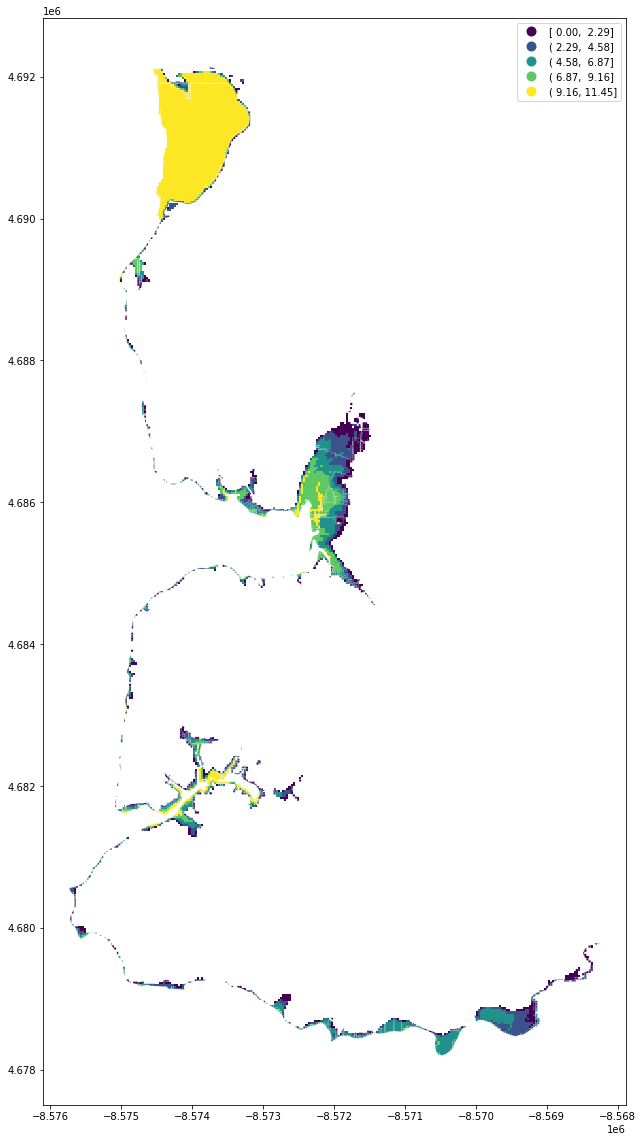

In [43]:
#f, axes = plt.subplots(figsize=(20, 10), ncols=3, nrows=1)
newDF.plot(column='BaseFLD',figsize=(30, 20), scheme= 'equal_interval', k=5, legend= True)
#newDF.plot(ax=axes[0][1], column='SeaLevel_1', scheme= 'equal_interval', k=5, legend= True)
#newDF.plot(ax=axes[0][2], column='SeaLevel_2',scheme= 'equal_interval', k=5, legend= True)

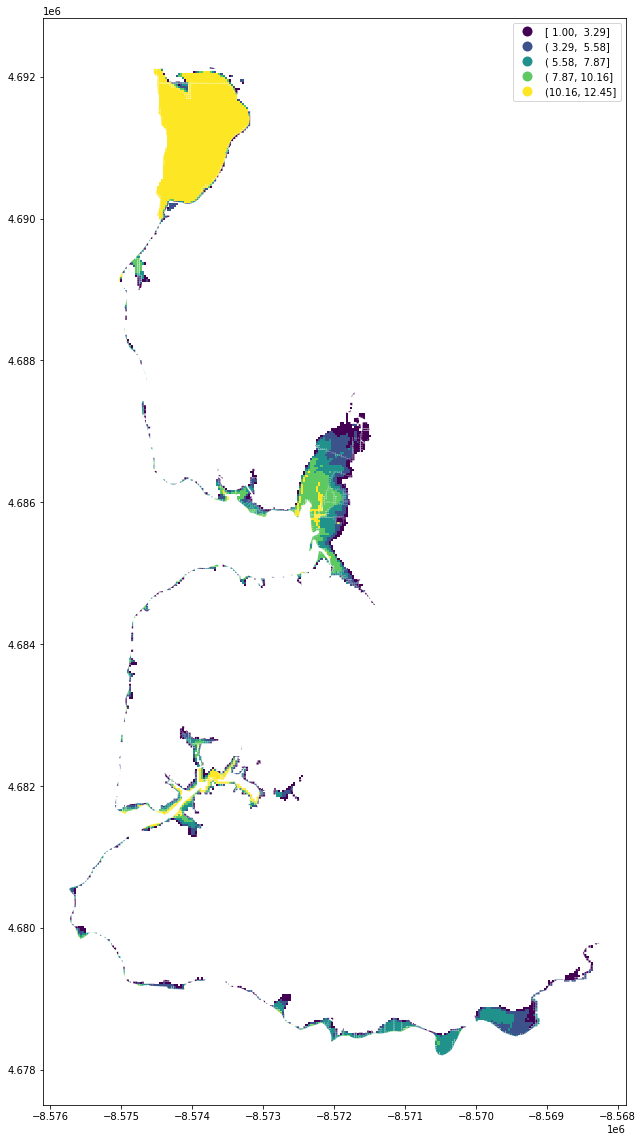

In [44]:
newDF.plot(column='SeaLevel_1',figsize=(30, 20), scheme= 'equal_interval', k=5, legend= True)

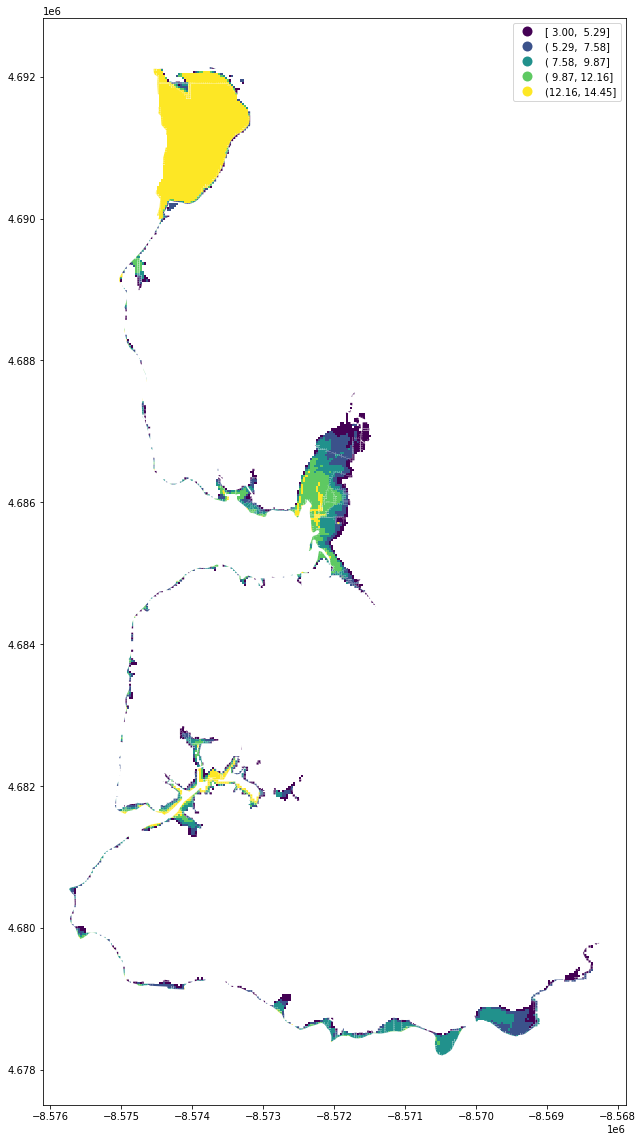

In [45]:
newDF.plot(column='SeaLevel_3',figsize=(30, 20), scheme= 'equal_interval', k=5, legend= True)